#TIME SERIES ANALYSIS

#Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

##DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP. You can get it in the github repo as well as here: http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/MTA_Fare.npy. 

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


In [1]:
import pylab as pl
import numpy as np
import pandas as pd
import json
import os
import operator
import matplotlib.pylab
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


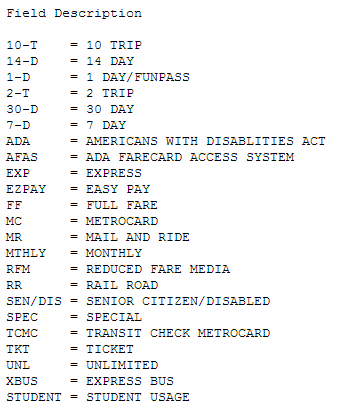

In [2]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

Each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/21/2010 to 02/21/2014. 

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

##note that the missing values are inputted as -1

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

In [3]:
mta = np.load('MTA_Fare.npy')
mta.shape

mta = np.where(mta !=-1, mta, np.nan)

In [4]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

#Task 1: 
##Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
##Identify it and figure out what it is due to.

In [5]:
mta_allsum = np.nansum(mta, axis=1)
print (mta_allsum.shape)

mta_allsum2 = np.nansum(mta, axis=0)
print (mta_allsum.shape)

#mta_allsum = np.nansum(mta, axis=2)
#print mta_allsum.shape

(600, 194)
(600, 194)


In [6]:
df = np.transpose(mta_allsum)
mtas = pd.DataFrame(df)

In [7]:
#194 weeks
#mtas.index = pd.Index(pd.date_range(pd.to_datetime('05/21/2010'), pd.to_datetime('02/21/2014'), freq='W'))
mtas.index = pd.Index(pd.date_range(pd.to_datetime('05/21/2010'), pd.to_datetime('02/08/2014'), freq='W'))
print mtas.index

DatetimeIndex(['2010-05-23', '2010-05-30', '2010-06-06', '2010-06-13',
               '2010-06-20', '2010-06-27', '2010-07-04', '2010-07-11',
               '2010-07-18', '2010-07-25', 
               ...
               '2013-12-01', '2013-12-08', '2013-12-15', '2013-12-22',
               '2013-12-29', '2014-01-05', '2014-01-12', '2014-01-19',
               '2014-01-26', '2014-02-02'],
              dtype='datetime64[ns]', length=194, freq='W-SUN', tz=None)


In [8]:
mtas.head

<bound method DataFrame.head of                0      1     2      3      4      5      6      7      8    \
2010-05-23  126878  37306  6606  16378  18564  19987  12449  11091  10482   
2010-05-30  149477  46464  6881  17408  19903  20625  13644  11659  11030   
2010-06-06  152383  49359  7229  17595  19948  21225  13719  12037  10881   
2010-06-13  160175  44849  5731  14242  16076  17412  11460   9809   9123   
2010-06-20  162641  41509  7032  17589  20283  20909  14094  11944  10923   
2010-06-27  156414  35654  5107  13168  14601  15589  10295   8586   8017   
2010-07-04  159156  41989  5497  14510  16151  17187  11504   9774   8963   
2010-07-11  159374  41909  5668  14388  16066  16897  11519   9651   8629   
2010-07-18  163285  41214  5555  14221  16205  16952  11449   9821   8844   
2010-07-25  159252  41142  6942  17180  19619  20563  13546  11568  10578   
2010-08-01  161573  41006  7015  17337  19375  20309  13645  11461  10925   
2010-08-08  157472  39797  6856  17312  1922

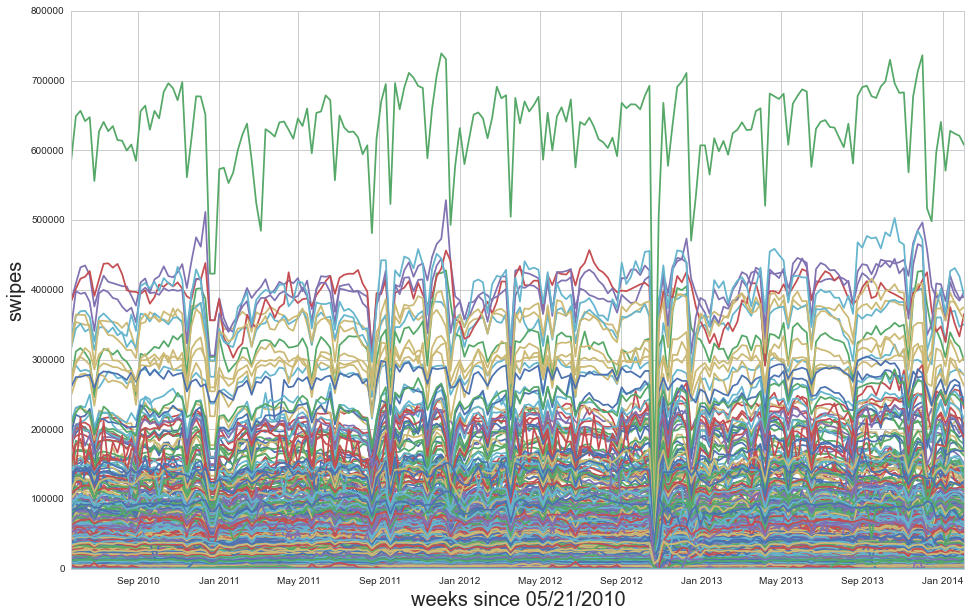

In [9]:
plt.figure(figsize=(16,10))
pl.plot(mtas.index, mtas)
pl.xlabel("weeks since 05/21/2010", fontsize=20)
pl.ylabel('swipes', fontsize=20)

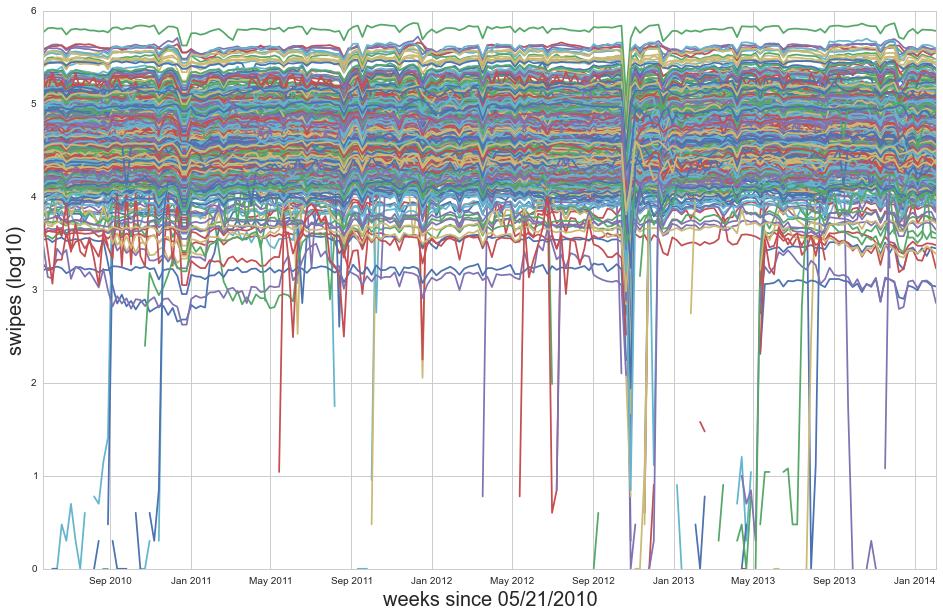

In [10]:
mtalog = np.log10(mtas)
plt.figure(figsize=(16,10))
pl.plot(mtas.index, mtalog)
pl.xlabel("weeks since 05/21/2010", fontsize=20)
pl.ylabel('swipes (log10)', fontsize=20)

In [11]:
#(>3-sigma) thresholds

mtamean = mtas.mean(axis=1)

thresholds = [mtamean.mean() + 3*mtamean.std(), 
              mtamean.mean() - 3*mtamean.std()]
print thresholds

[64593.98762562647, 34677.178611486976]


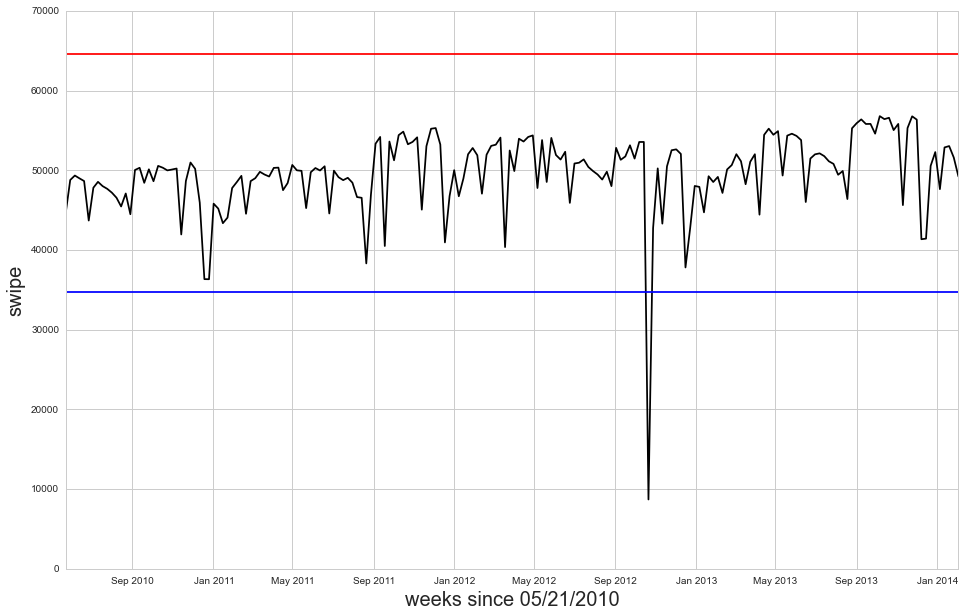

In [12]:
plt.figure(figsize=(16,10))
pl.plot(mtamean.index, mtamean, color='k')
pl.axhline(thresholds[0], color='r', linestyle='-')
pl.axhline(thresholds[1], color='b', linestyle='-')
pl.xlabel("weeks since 05/21/2010", fontsize=20)
pl.ylabel('swipe', fontsize=20)


### The sudden drop between Sept. 2012 - Jan. 2013 is caused by Hurricane Sandy that happened in Oct 22, 2012. 

#Task 2: 
##Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

In [13]:
mta_allsum2 = np.nansum(mta, axis=0)
mta2 = np.transpose(mta_allsum2)
mta2 = pd.DataFrame(mta2)
print (mta2.shape)

(194, 23)


In [14]:
mta2 = pd.DataFrame(mta2)
mta2.index = pd.Index(pd.date_range(pd.to_datetime('05/21/2010'), pd.to_datetime('02/08/2014'), freq='W'))

mta2.columns = ridetype
mta2[:10]

10t     14d     1d      2t    30d       7d      ada   afas  \
2010-05-23  11494615  530524  47801  186551  46808  3697443  8551937  10063   
2010-05-30  12526859  583533  51486  199229  64353  3981808  9486394  11847   
2010-06-06  12766627  586194  51636  199668  56994  4033030  9476538  12277   
2010-06-13  12653675  562602  52063  196389  37429  4032753  9450081  11221   
2010-06-20  12809694  548858  51153  194883  35210  3925446  9294002  10515   
2010-06-27  11429783  455691  46852  175648  46849  3663144  8286803  10282   
2010-07-04  12346877  518187  48963  188467  60225  3918104  9271413  11361   
2010-07-11  12576759  513412  49629  188090  47439  4028251  9306575  10950   
2010-07-18  12437115  512192  49030  186822  32084  4030717  9145852  10723   
2010-07-25  12431257  522569  50376  190528  52171  4032340  8906117  10574   

               exp      ez  ...    month     rfm     rr    sen  spec    tcmc  \
2010-05-23  333197  512032  ...   123134  790110  59809  28221     0  124693   
2010-05-30  282755  578023  ...   151948  908068  69209  32333     0  121713   
2010-06-06  302028  615537  ...   151538  914124  69574  32618     0  122181   
2010-06-13  305513  606270  ...   147094  902549  68099  32404     0  122051   
2010-06-20  335780  563446  ...   137888  855573  66377  31933   176  119776   
2010-06-27  346683  540555  ...   111425  730531  54034  27469     1  113699   
2010-07-04  310387  611962  ...   140932  838630  65635  32065     2  114803   
2010-07-11  345722  653871  ...   138075  845227  65351  32159     3  120293   
2010-07-18  348569  658757  ...   136229  832235  64066  31284     0  123578   
2010-07-25  364363  651734  ...   134701  823236  63006  31600  4358  125819   

                t  umlim  xbus  stud  
2010-05-23  21060   6128   358     0  
2010-05-30  21670   6120   474     0  
2010-06-06  21433   6490   465     0  
2010-06-13  21630   6590   484     0  
2010-06-20  20297   6313   452     0  
2010-06-27  19800   6158   458     0  
2010-07-04  20816   6793   535     0  
2010-07-11  21497   7182   527     0  
2010-07-18  21620   7116   503     0  
2010-07-25  21488   7373   506     0  

[10 rows x 23 columns]

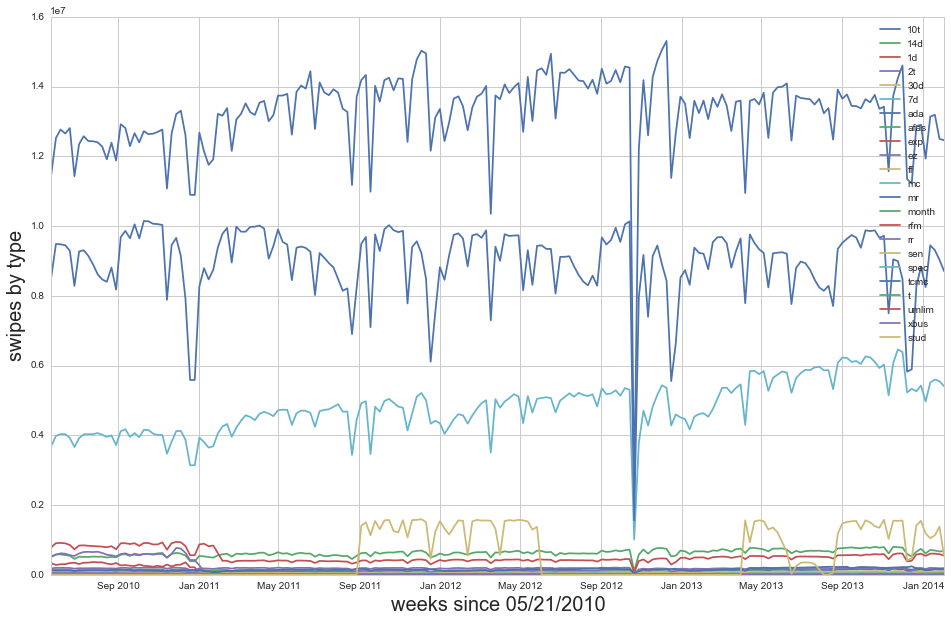

In [15]:
#ridership types
plt.figure(figsize=(16,10))
pl.plot(mta2.index, mta2)
pl.xlabel("weeks since 05/21/2010", fontsize=20)
pl.ylabel('swipes by type', fontsize=20)
pl.legend(mta2.columns)

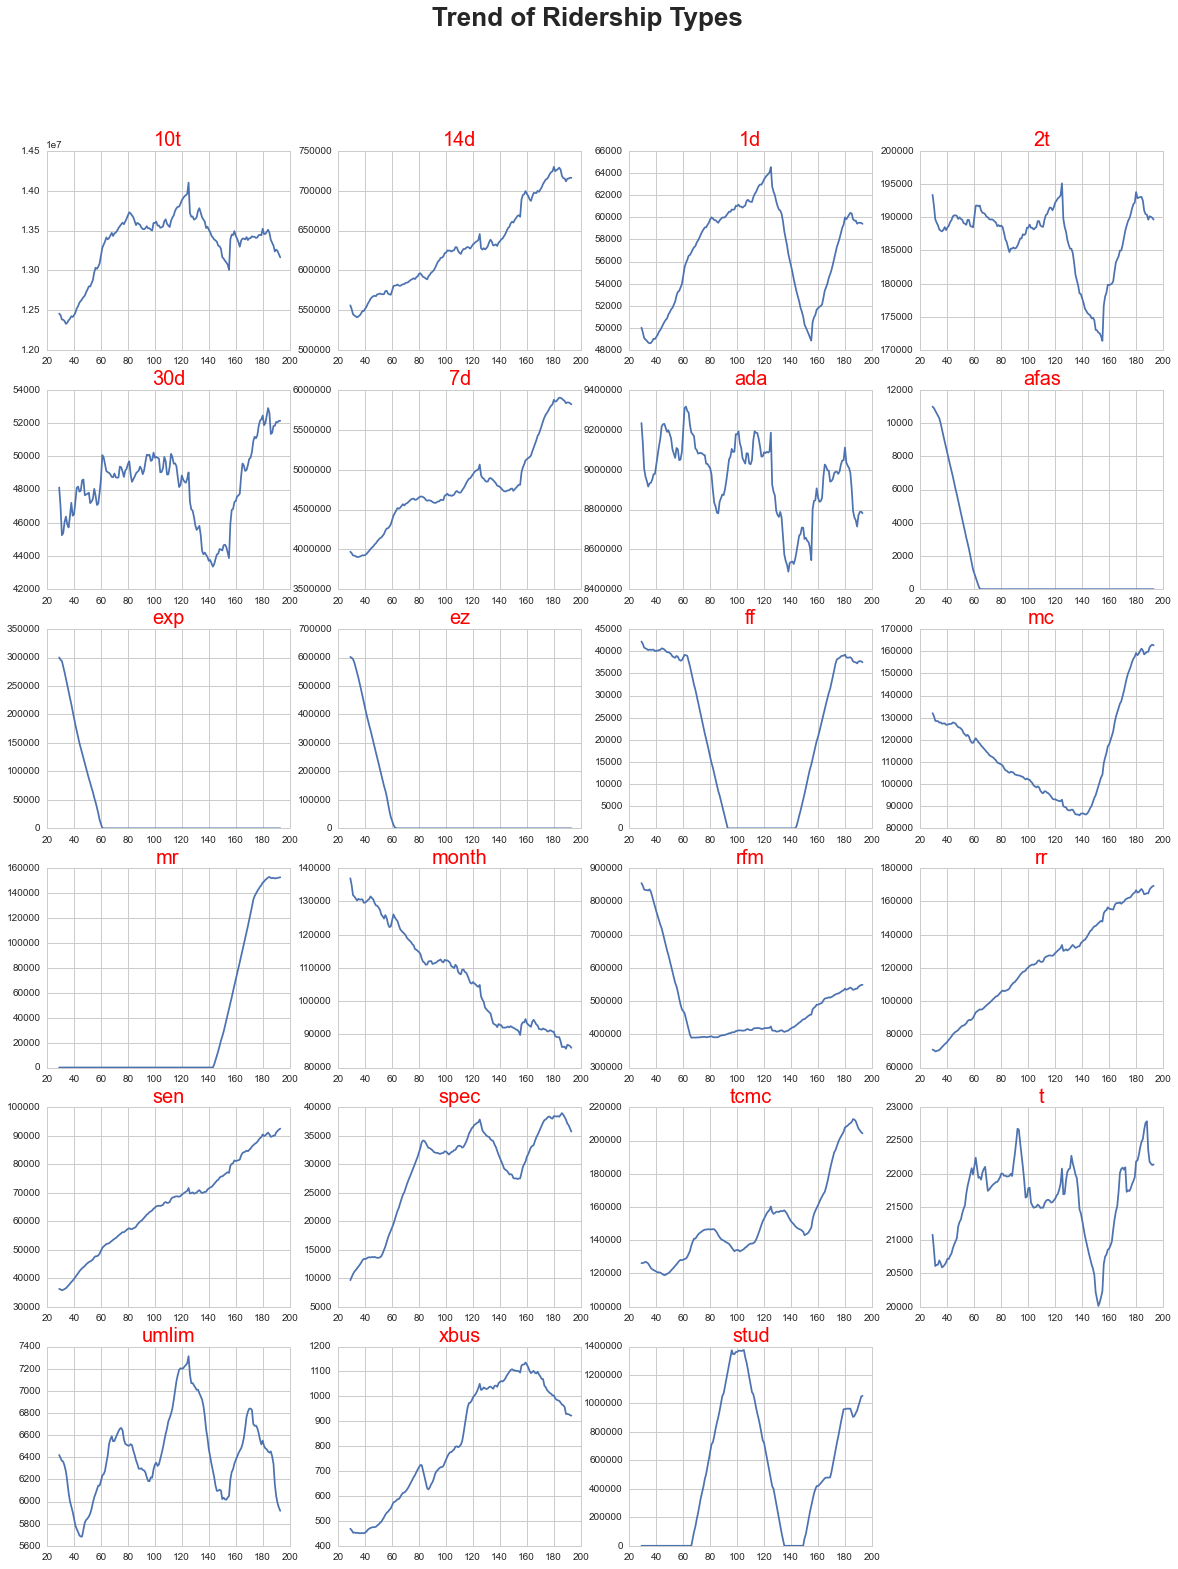

In [16]:
fig = pl.figure(figsize=(20,25))
fig.suptitle('Trend of Ridership Types', fontweight='bold', fontsize=26)

x = 0
for i in ridetype:
    ax = fig.add_subplot(6,4,x+1)
    y = pd.rolling_mean(mta2[i], 30)
    ax.plot(y)
    ax.set_title(i, fontsize=20, color='r')
    x = x+1

### Ridership types that have:
    steadily increased in popularity: 14d, 7d, rr, sen
    steadily decreased in popularity: month

In [17]:
#Ratio of first 10 and last 10 weeks
for i in ridetype:
    ratio = mta2[i].head(10).mean()/mta2[i].tail(10).mean()
    print ('Ratio usage of %s is %s' % (i,ratio))


Ratio usage of 10t is 0.978667087302
Ratio usage of 14d is 0.79868054602
Ratio usage of 1d is 0.899810476622
Ratio usage of 2t is 1.07088927164
Ratio usage of 30d is 0.967317176485
Ratio usage of 7d is 0.719555117345
Ratio usage of ada is 1.11130702032
Ratio usage of afas is 4774.47826087
Ratio usage of exp is 93571.3428571
Ratio usage of ez is 665798.555556
Ratio usage of ff is 1.22129628533
Ratio usage of mc is 0.824035088267
Ratio usage of mr is 4.03470963308e-05
Ratio usage of month is 1.72794422105
Ratio usage of rfm is 1.53938888675
Ratio usage of rr is 0.385659649203
Ratio usage of sen is 0.343713862169
Ratio usage of spec is 0.0142485908332
Ratio usage of tcmc is 0.652626042706
Ratio usage of t is 0.978867204328
Ratio usage of umlim is 1.23599634403
Ratio usage of xbus is 0.601566447701
Ratio usage of stud is 0.0




#Task 3:
##Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [18]:
mta3 = pd.DataFrame(mta_allsum)
#fourier = np.fft.rfft(signal)
f = np.abs(np.fft.rfft(mta3[0]))
sample_rate = 1
n = mta3[0].size
freq = np.fft.rfftfreq(n, d=1./sample_rate)
fft = np.fft.rfftfreq(n, 1.0)
print mta3.shape
print f.shape
print fft.shape
#print freq
#print mta3.size

(600, 194)
(301,)
(301,)


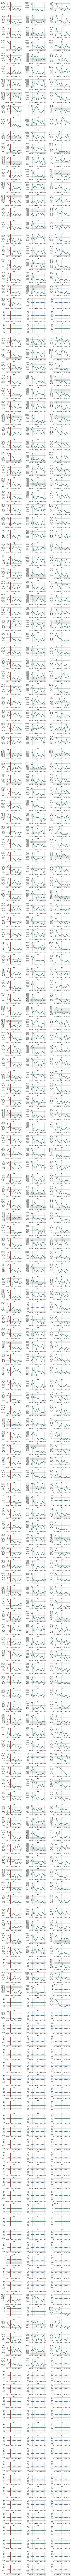

In [19]:
fig = pl.figure(figsize=(10,400))
a = {}
for i in range(600):
    a[i] = np.abs(np.fft.rfft(mta_allsum[i])[4])
    
    ax = fig.add_subplot(200,3,i+1)
    f = np.abs(np.fft.rfft(mta3.loc[i,:]))
    
    ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f[1:]), 'o', ms=8)
    ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f[1:]), '-')
    ax.set_title(i)
    plt.axvline(1.0/52, color='r')
    ax.set_xlim(0,1.0/15)
    pl.subplots_adjust(wspace=.5, hspace=.5, left=.1, bottom=.1)

In [25]:
annual = sorted(a.items(), key=operator.itemgetter(1))
print annual[596:600]

[(327, 2402218.5809588572), (150, 2931895.8769513383), (194, 2950388.929214194), (0, 2980160.6355953491)]


### Stations that show the most prominent periodic trend: 
    0, 150, 194, and 327.

#EXTRA CREDIT: Cluster. 
##Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
##Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

##i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T

##removing empty light curves
tots = tots[tots.std(1)>0]

##with Kmeans you have to choose the number of clusters ahead km = 

KMeans(n_clusters=10)

##and standardize the lightcurves before clustering
vals = ((tots.T - tots.mean(1))/tots.std(1)).T

##then you can run:

km.fit(vals)

In [21]:
tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T

NameError: name 'data' is not defined